In [20]:
import pandas as pd
import numpy as np
import mysql.connector as msql
import seaborn as sns
import matplotlib.pyplot as plt
# This file contains our login information for the MySQL server
import credentials as C
import warnings

Let's connect to the database we created earlier in the process

In [2]:
try:
    conn = msql.connect(host = C.host_name, database = 'creditcard_capstone', 
                        user = C.user_name, password = C.password)
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
except msql.Error as e:
    print('Error while connecting to MySQL',e)

You're connected to database:  ('creditcard_capstone',)


# 1. Find and plot which transaction type has a high rate of transactions.

Let's pull the relevant data from the db

In [9]:
type_count_sql=("SELECT TRANSACTION_TYPE, count(TRANSACTION_TYPE) "
                "FROM cdw_sapp_credit_card "
                "GROUP BY TRANSACTION_TYPE "
                "ORDER BY TRANSACTION_TYPE")
cursor.execute(type_count_sql)   #cursor was assigned in the connect_sql() function
result = cursor.fetchall()

trans_types = []
trans_count = []

for row in result:
    trans_types.append(row[0])
    trans_count.append(row[1]) 

When pulling the data we put the values of each column into their own python lists, trans_types and trans_count.  We will pass those lists as the x and y values of the seaborn barplot function.

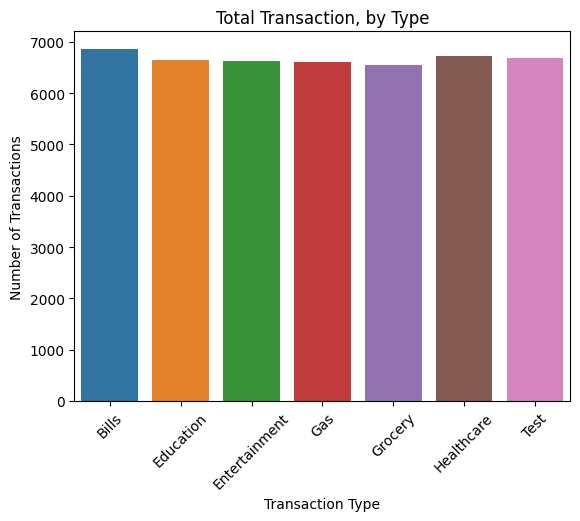

In [49]:
sns.barplot(x = trans_types, y = trans_count)

# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45)

plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.title("Total Transactions, by Type")
plt.show()

This data doesn't seem to tell us much.  Let's see if the data changes throughout the year.  First, lets group the data by month using a SQL statement.  I am choosing to use a pandas dataframe for this because seaborn easily accepts the dataframe with no other arguments to easily build the plot.

In [25]:
type_count_per_month_sql = ("SELECT SUBSTRING(TIMEID,5,2) AS mon, "
                            "    SUM(TRANSACTION_TYPE = 'Bills') AS Bills, "
                            "    SUM(TRANSACTION_TYPE = 'Education') AS Education, "
                            "    SUM(TRANSACTION_TYPE = 'Entertainment') AS Entertainment, "
                            "    SUM(TRANSACTION_TYPE = 'Gas') AS Gas, "
                            "    SUM(TRANSACTION_TYPE = 'Grocery') AS Grocery, "
                            "    SUM(TRANSACTION_TYPE = 'Healthcare') AS Healthcare, "
                            "    SUM(TRANSACTION_TYPE = 'Test') AS Test "
                            "FROM cdw_sapp_credit_card "
                            "GROUP BY mon "
                            "ORDER BY mon")

# This warning filter is needed to suppress a warning pandas prints when connecting
# using a connection engine other than SQLAlchemy
warnings.filterwarnings('ignore')

type_count_per_month_df = pd.read_sql(type_count_per_month_sql, conn)
type_count_per_month_df

,mon,Bills,Education,Entertainment,Gas,Grocery,Healthcare,Test
0,01,530.0,532.0,556.0,578.0,526.0,548.0,544.0
1,02,599.0,537.0,566.0,584.0,555.0,552.0,566.0
2,03,565.0,533.0,564.0,545.0,532.0,566.0,546.0
3,04,588.0,534.0,563.0,528.0,540.0,558.0,529.0
4,05,586.0,559.0,550.0,524.0,568.0,584.0,575.0
5,06,581.0,540.0,549.0,538.0,548.0,527.0,536.0
6,07,561.0,601.0,581.0,529.0,545.0,549.0,569.0
7,08,570.0,560.0,513.0,544.0,566.0,559.0,549.0
8,09,572.0,577.0,520.0,548.0,557.0,564.0,548.0
9,10,581.0,550.0,547.0,553.0,534.0,619.0,562.0


Lets put this data in a lineplot.

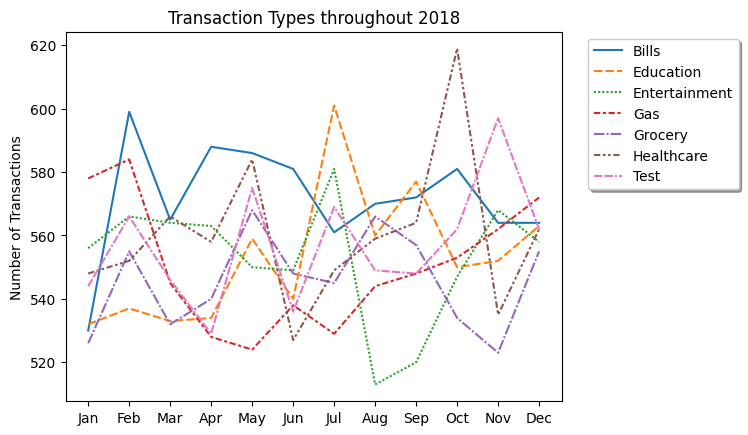

In [52]:
mon_words = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
multi_line_chart = sns.lineplot(data = type_count_per_month_df)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fancybox=True, shadow=True)
multi_line_chart.set_xticks(range(len(type_count_per_month_df)), labels = mon_words)
plt.ylabel('Number of Transactions')
plt.title('Transaction Types throughout 2018')
# .gcf() get the current figure and we save it to fig.  doing this allows up to 
# show the current plot again in the future without redeclaring all the pre stuff
fig = plt.gcf()
plt.show()

Seems a bit all over the place.  But if you look at the y axis, it doesn't seem to be start at 0 so let's change that to see if it changes anything.

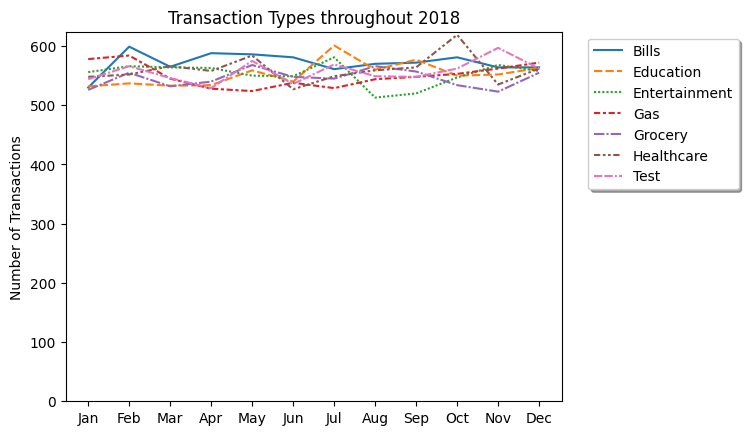

In [55]:
# normally I would use fig.show() to show the figure but in jupyter you have to use just fig
multi_line_chart.set_ylim(bottom=0)
fig

There doesn't seem to be much of a change after setting the y axis to start at 0.  All the transactions seem to be grouped around the 500-600/month range. 

Let's see what the data looks like between two specific months.  We can change which time period we want the data to span

In [58]:
year_start = "2018"
month_start = "2"
year_end = "2018"
month_end = "10"

In [60]:
# month needs to be in MM format so we will pad a leading 0 to the given number
month_start = month_start.rjust(2, "0")
month_end = month_end.rjust(2, "0")

type_count_timespan_sql = ("SELECT SUBSTRING(TIMEID,5,2) AS mon, "
                            "    SUM(TRANSACTION_TYPE = 'Bills') AS Bills, "
                            "    SUM(TRANSACTION_TYPE = 'Education') AS Education, "
                            "    SUM(TRANSACTION_TYPE = 'Entertainment') AS Entertainment, "
                            "    SUM(TRANSACTION_TYPE = 'Gas') AS Gas, "
                            "    SUM(TRANSACTION_TYPE = 'Grocery') AS Grocery, "
                            "    SUM(TRANSACTION_TYPE = 'Healthcare') AS Healthcare, "
                            "    SUM(TRANSACTION_TYPE = 'Test') AS Test "
                            "FROM cdw_sapp_credit_card "
                            f"WHERE TIMEID BETWEEN '{year_start}{month_start}%' AND '{year_end}{month_end}%' "
                            "GROUP BY mon "
                            "ORDER BY mon")
                            
# This warning filter is needed to suppress a warning pandas prints when connecting
# using a connection engine other than SQLAlchemy
warnings.filterwarnings('ignore')

type_count_timespan_df = pd.read_sql(type_count_timespan_sql, conn)
type_count_timespan_df

,mon,Bills,Education,Entertainment,Gas,Grocery,Healthcare,Test
0,02,599.0,537.0,566.0,584.0,555.0,552.0,566.0
1,03,565.0,533.0,564.0,545.0,532.0,566.0,546.0
2,04,588.0,534.0,563.0,528.0,540.0,558.0,529.0
3,05,586.0,559.0,550.0,524.0,568.0,584.0,575.0
4,06,581.0,540.0,549.0,538.0,548.0,527.0,536.0
5,07,561.0,601.0,581.0,529.0,545.0,549.0,569.0
6,08,570.0,560.0,513.0,544.0,566.0,559.0,549.0
7,09,572.0,577.0,520.0,548.0,557.0,564.0,548.0


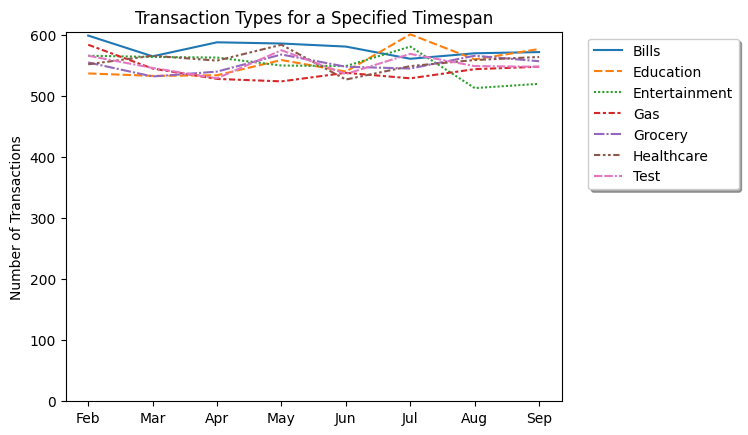

In [67]:
multi_line_timespan_chart = sns.lineplot(data = type_count_timespan_df)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fancybox=True, shadow=True)
# since the mon_words list contains all 12 months we can't pass the entire list into the labels param.  So we will
# use the input that the user entered for the months and convert them to ints and then use them as index pos for the list
multi_line_timespan_chart.set_xticks(range(len(type_count_timespan_df)), labels = mon_words[int(month_start)-1:int(month_end)-1])
multi_line_timespan_chart.set_ylim(bottom=0)
plt.ylabel('Number of Transactions')
plt.title('Transaction Types for a Specified Timespan')
plt.show()

There doesn't seem to be a transaction type that stands out above the rest when looking at the number of transactions.

2. Find and plot which state has a high number of customers.

3. Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.
Hint (use CUST_SSN). 